In [1]:
%matplotlib inline

In [2]:
import gym
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import random

In [3]:
from experiencereplay import ExperienceReplay, PrioritizedExperienceReplay
from experiment import Experiment
from ddpg import DDPG
import nn

In [4]:
settings = dict(
    environment = 'Pendulum-v0',
    timesteps = 3000,
    max_replay_buffer_size = 100000,
    batch_size = 256,
    learning_start = 256,
    discount_factor = 0.9,
    tf_optimizer = tf.train.AdamOptimizer(0.001),
    train_updates_per_step = 10,
    priority_updates_per_step = 100,
    
    actor_net_layers = [256, 128],
    actor_net_activation_fn = tf.nn.relu,
    actor_bounded_output = True,
    q_net_layers =  [256, 128],
    q_net_activation_fn = tf.nn.relu,
    
    gpu_memory_fraction = 0.1,
    
    render_environment = True,
    render_frequency = 60
)

In [5]:
env = gym.make(settings["environment"])

observation = np.array(env.reset())
state = observation

[2017-04-13 20:38:00,635] Making new env: Pendulum-v0


In [6]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(state_dim)
print(action_dim)
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.high)
print(env.action_space.low)

3
1
[ 1.  1.  8.]
[-1. -1. -8.]
[ 2.]
[-2.]


In [7]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=settings["gpu_memory_fraction"])
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [8]:
actor_network = nn.fully_connected("Actor", session, [state_dim], settings["actor_net_layers"],
                                   action_dim, settings["actor_net_activation_fn"],
                                   env.action_space if settings["actor_bounded_output"] else None, False)
q_network = nn.fully_connected("Q", session, [state_dim, action_dim], settings["q_net_layers"], 1,
                               settings["q_net_activation_fn"], None, False)

print(str(actor_network))

[] --> Actor_input_0
['Actor_input_0'] --> hidden_0_256
['hidden_0_256'] --> hidden_1_128
['hidden_1_128'] --> output
['output'] --> bounding



In [9]:
agent = DDPG(actor_network, q_network, discount_factor=settings["discount_factor"],
             tf_optimizer=settings["tf_optimizer"])

In [10]:
experience_replay = PrioritizedExperienceReplay(agent, settings["max_replay_buffer_size"])

In [11]:
exp = Experiment(env, settings, settings["render_environment"], settings["render_frequency"])

progress_bar = tqdm(total=settings["timesteps"])

for t in xrange(settings["timesteps"]):   
    exploration_probability = ((settings["timesteps"] - t) / float(settings["timesteps"])) ** 2
    if t < settings["learning_start"]:
        exploration_probability = 1
    
    if random.uniform(0, 1) < exploration_probability:
        action = env.action_space.sample()
    else:
        action = agent.action(state)
    
    observation, reward, done, info = env.step(action)
    next_state = np.reshape(observation, (state_dim,))
    
    experience_replay.add_experience(state, action, reward, next_state, done)
    td_error = math.fabs(experience_replay.get_last_td_error())
    exp.record(t, state, action, reward, next_state, done, td_error)
    
    state = next_state
    
    if done:
        state = np.array(env.reset())
        
    if t >= settings["learning_start"]:
        experience_replay.train_agent(settings["batch_size"], settings["train_updates_per_step"])
        experience_replay.update_oldest_priorities(settings["priority_updates_per_step"])
            
    progress_bar.set_description('[{}] reward: {:.2f}, reward 100-step MA: {:.2f}, Exploration proba: {:.2f}, action: {}, td-error: {:.4f}' \
        .format(t, reward, exp.reward_100ma.get_average(), exploration_probability, str(action), td_error))
    progress_bar.update()
    
        
progress_bar.close()

[2999] reward: -0.00, reward 100-step MA: -0.00, Exploration proba: 0.00, action: [-0.57496089], td-error: 0.3852: 100%|██████████| 3000/3000 [04:21<00:00, 11.49it/s] | 1/3000 [00:00<42:44,  1.17it/s]


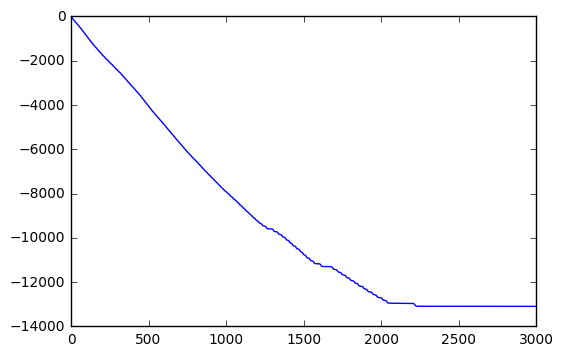

In [12]:
exp.plot_cumulative_reward()

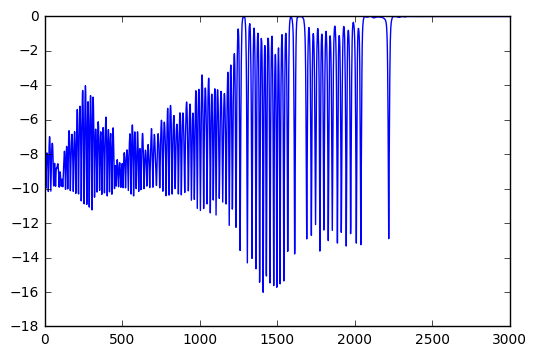

In [13]:
exp.plot_reward()

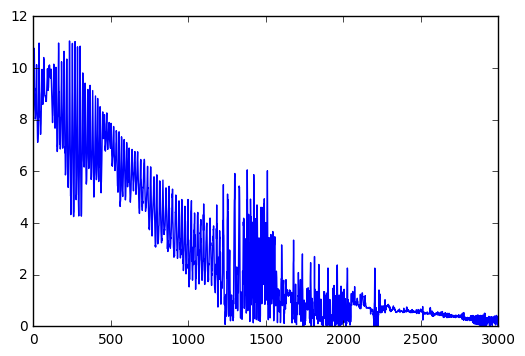

In [14]:
exp.plot_td_error()


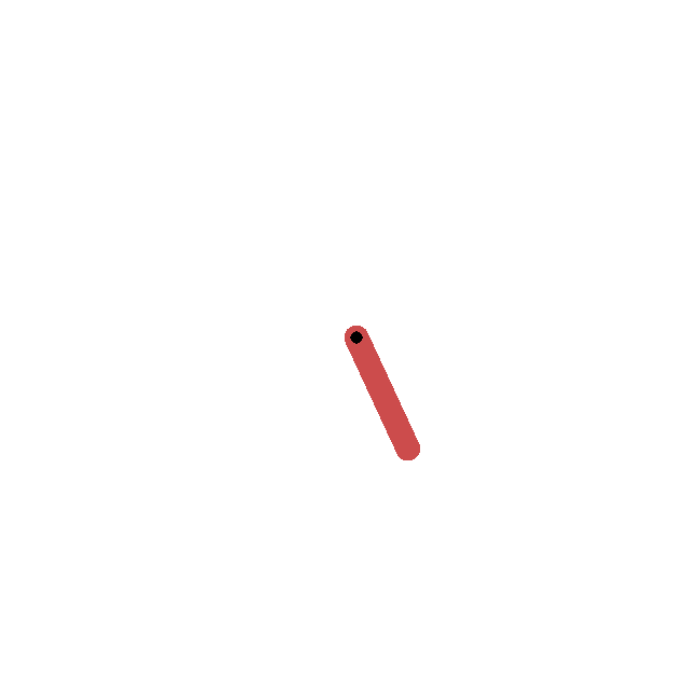
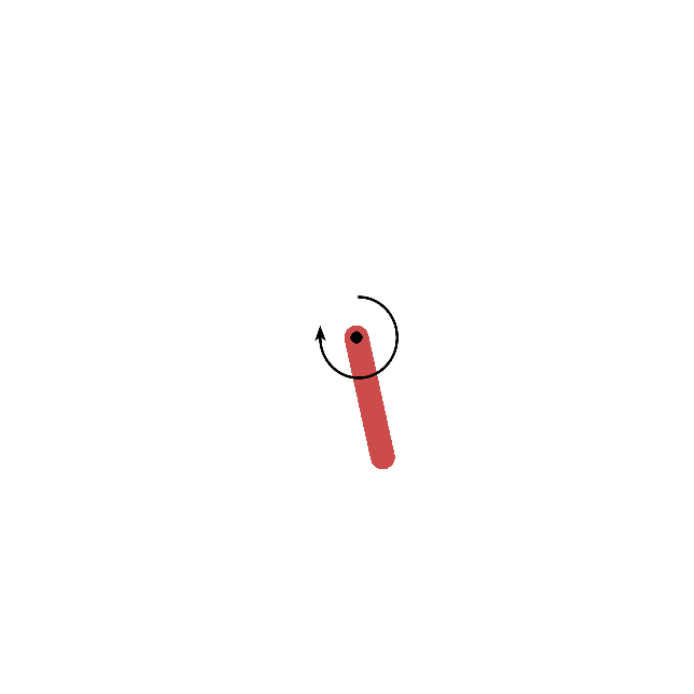
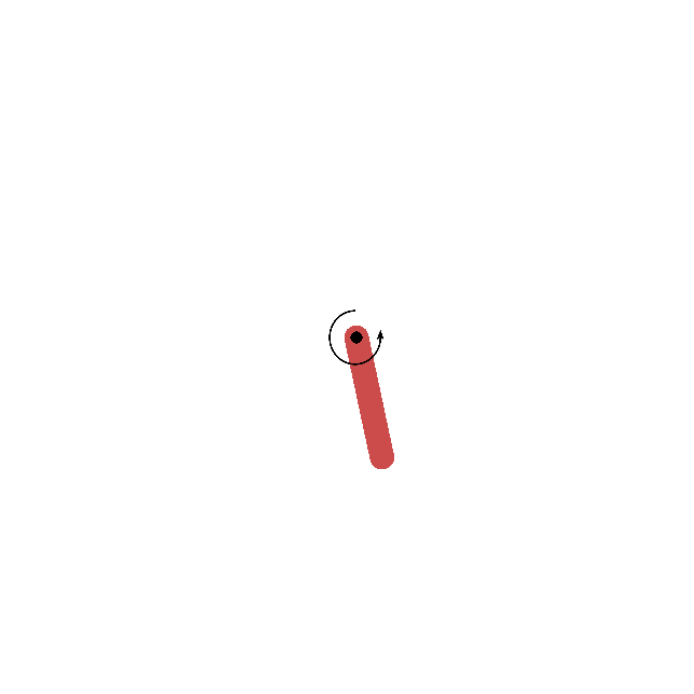
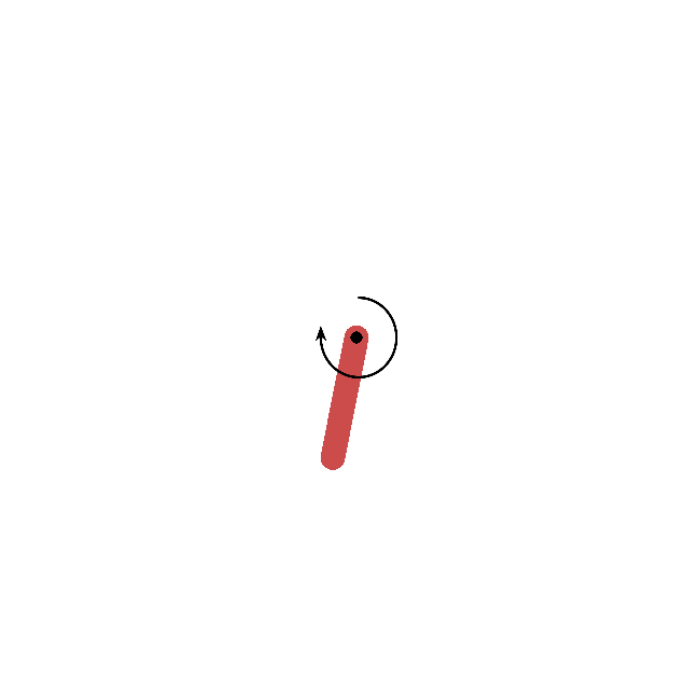
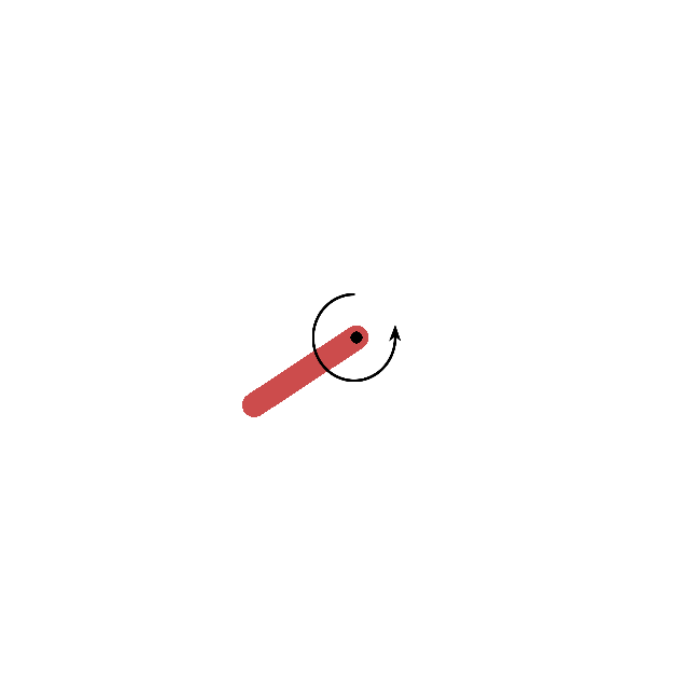
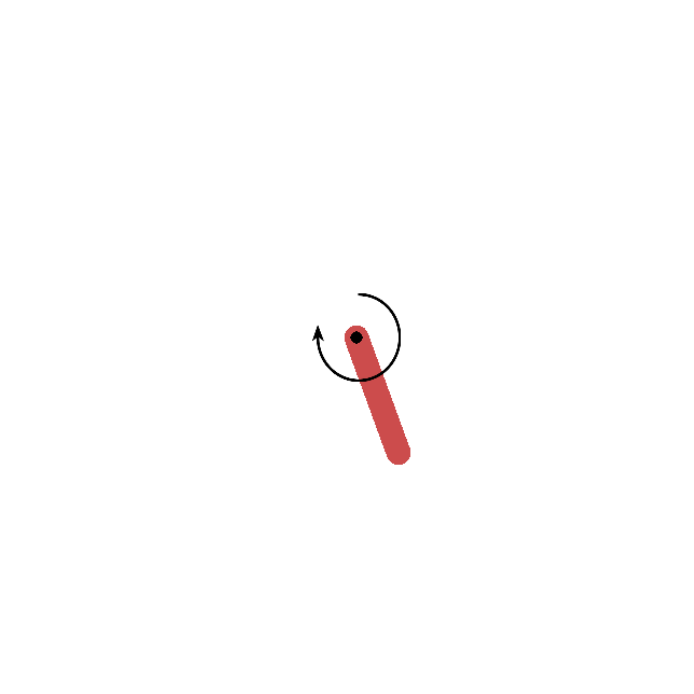
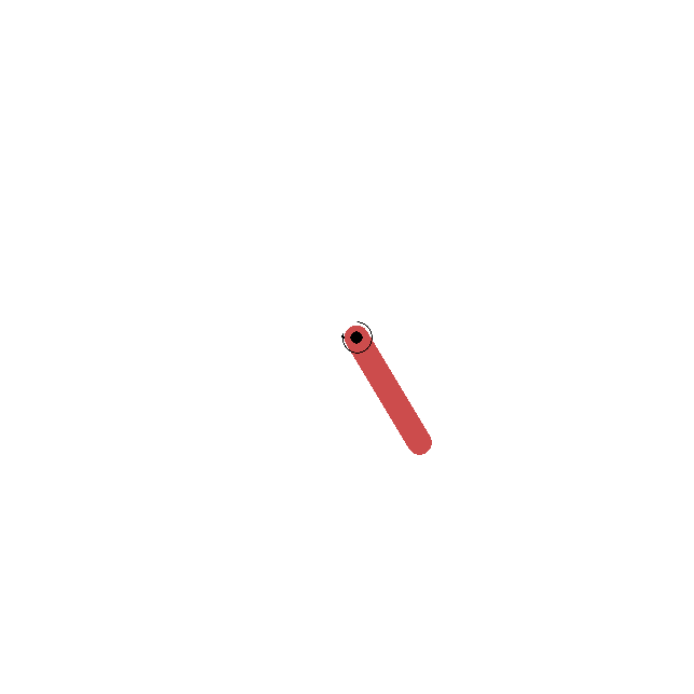
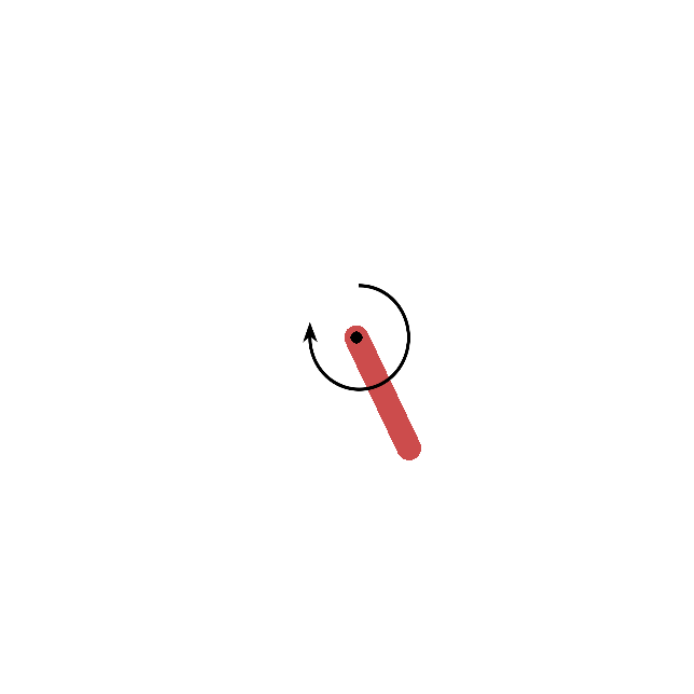
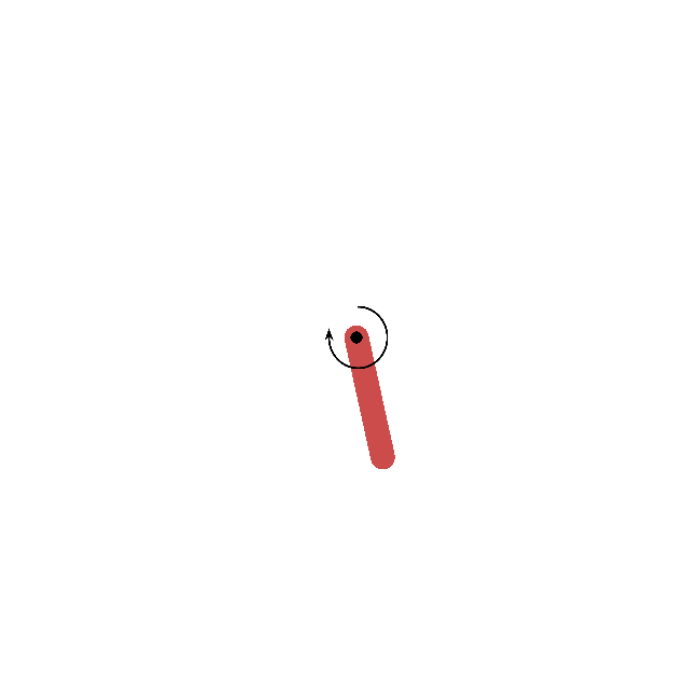
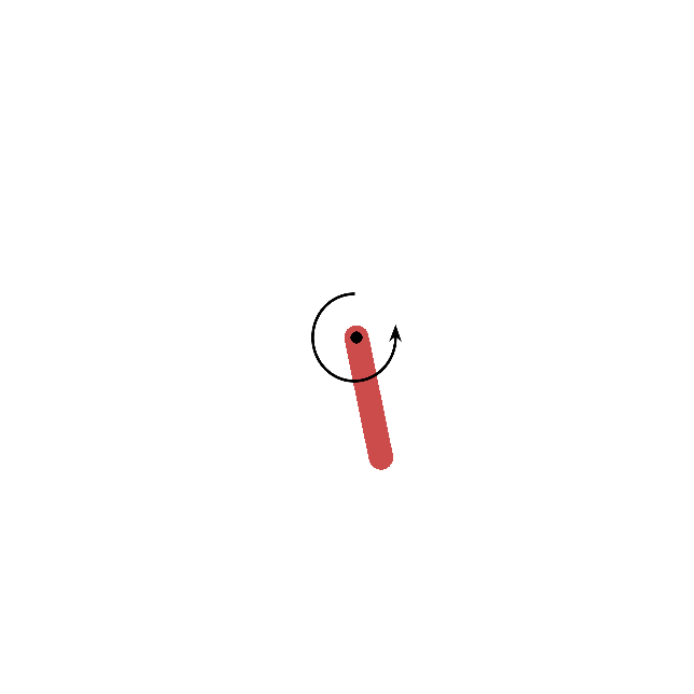
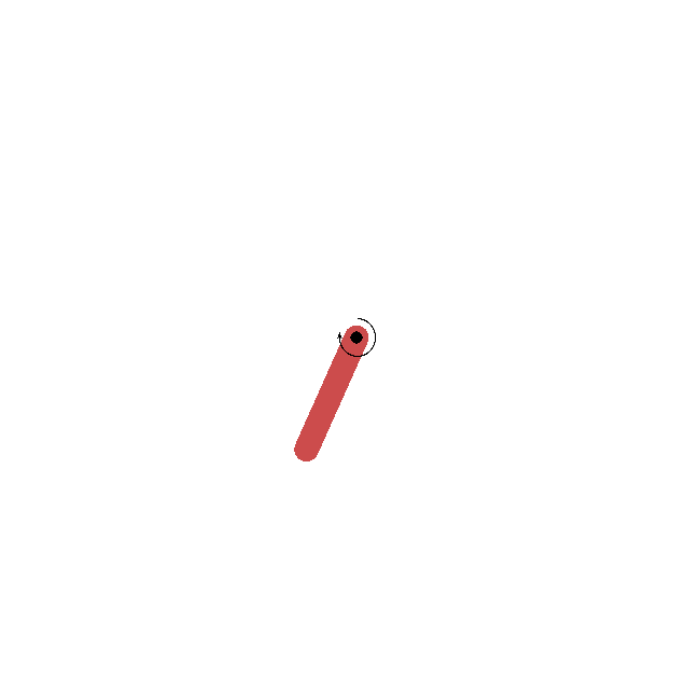
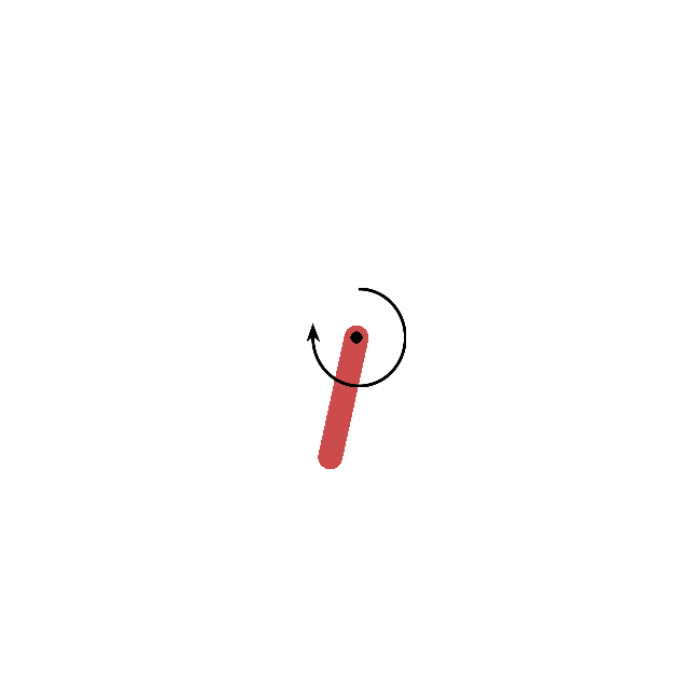
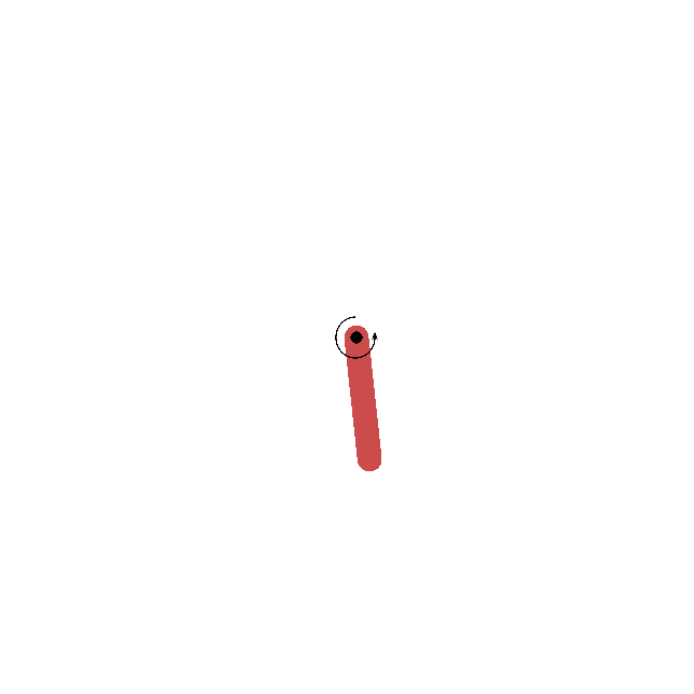
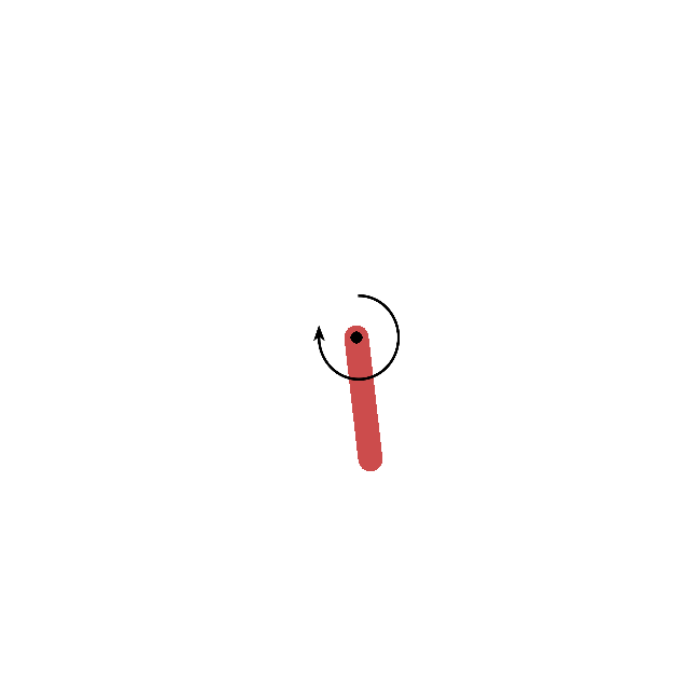
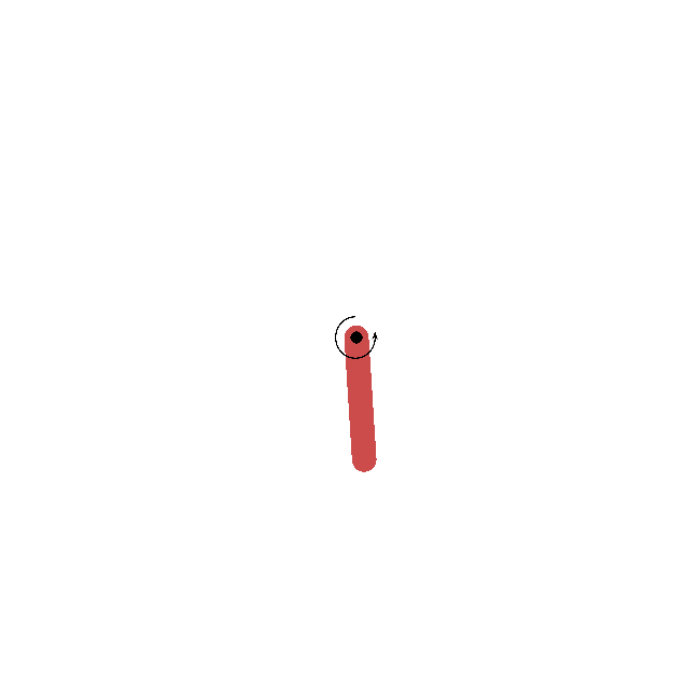
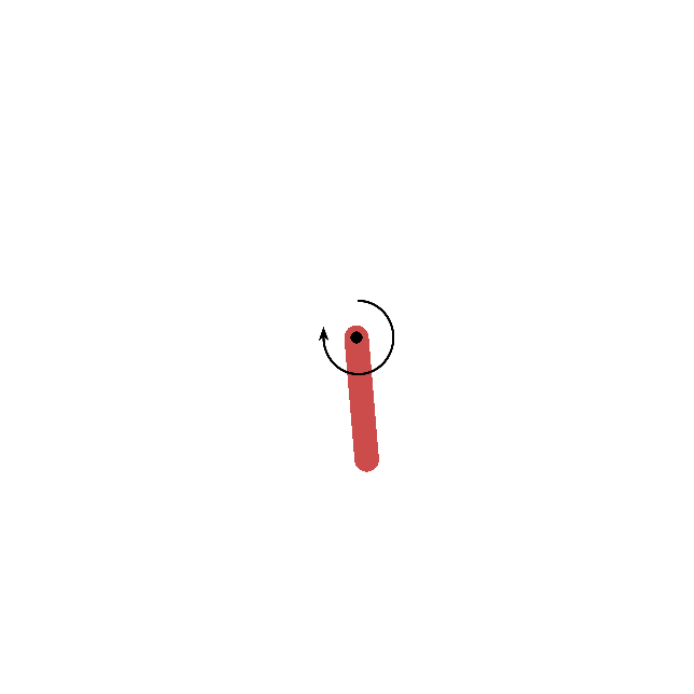
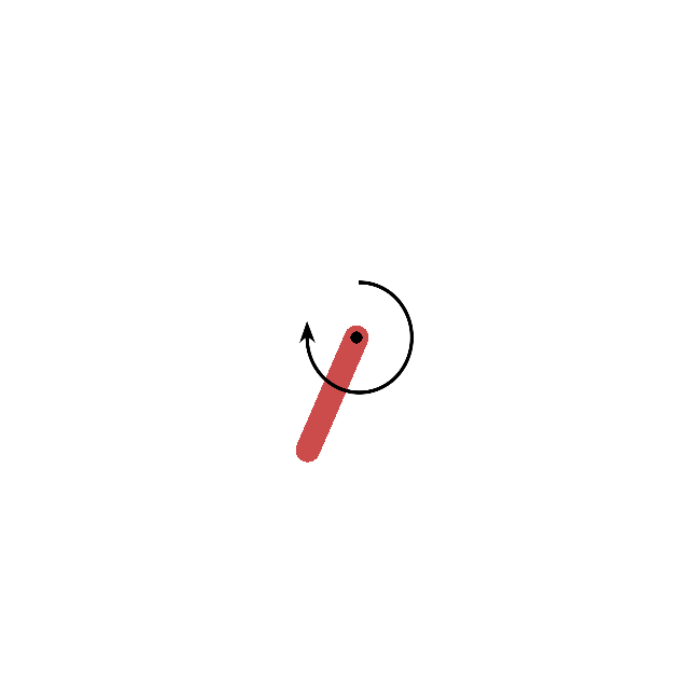
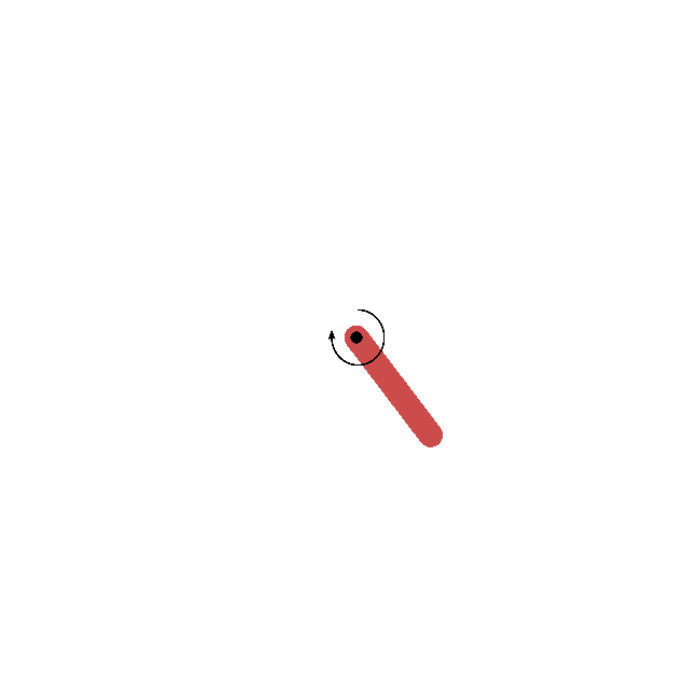
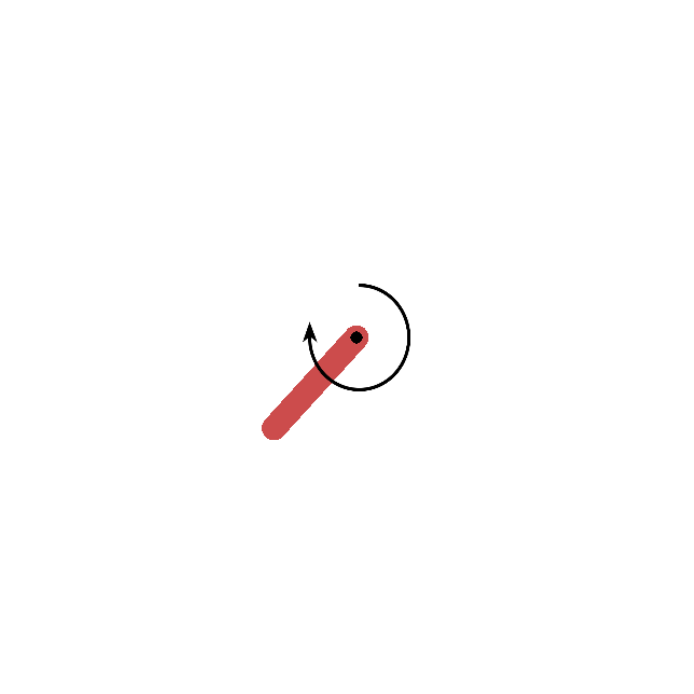
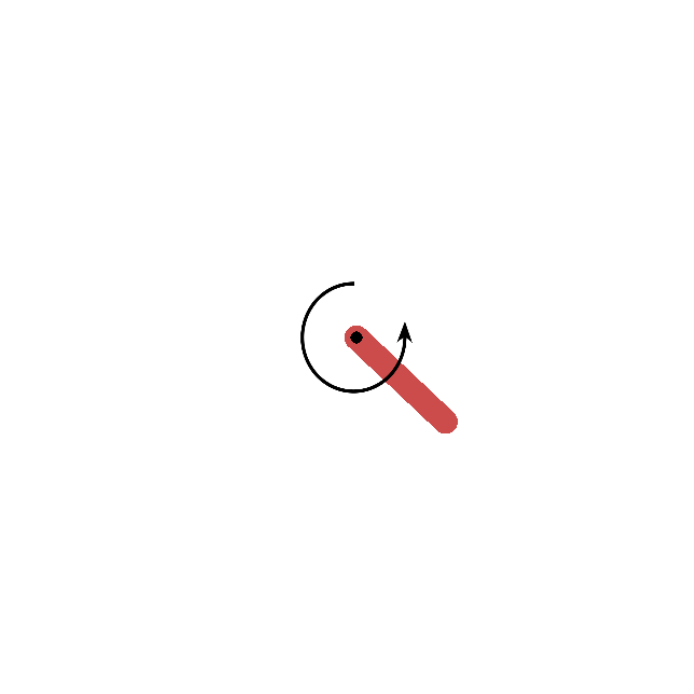
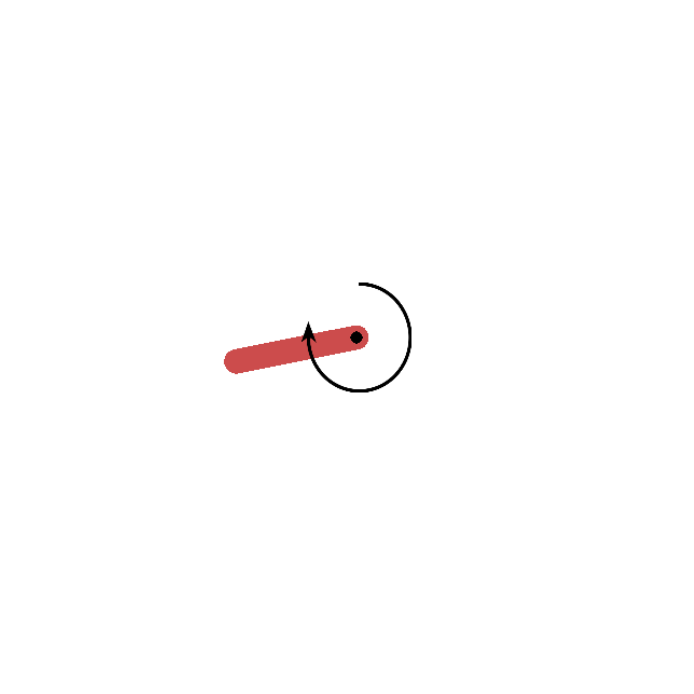
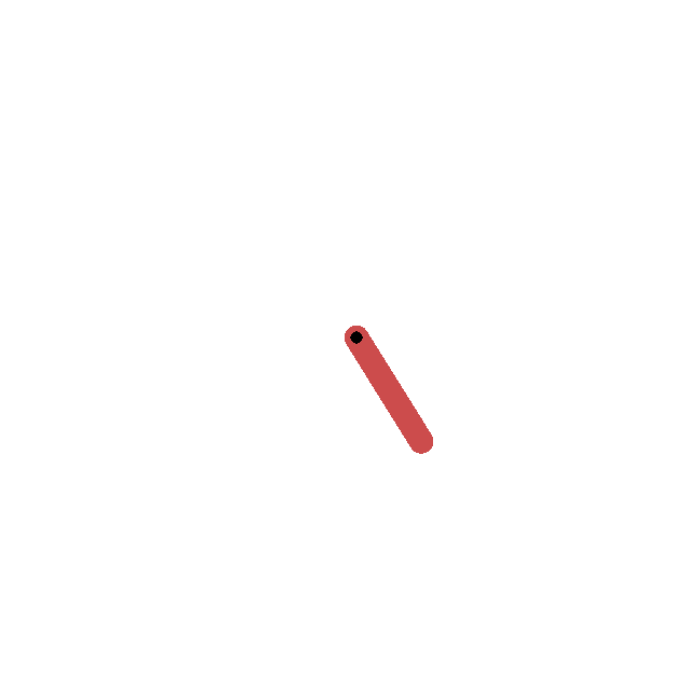
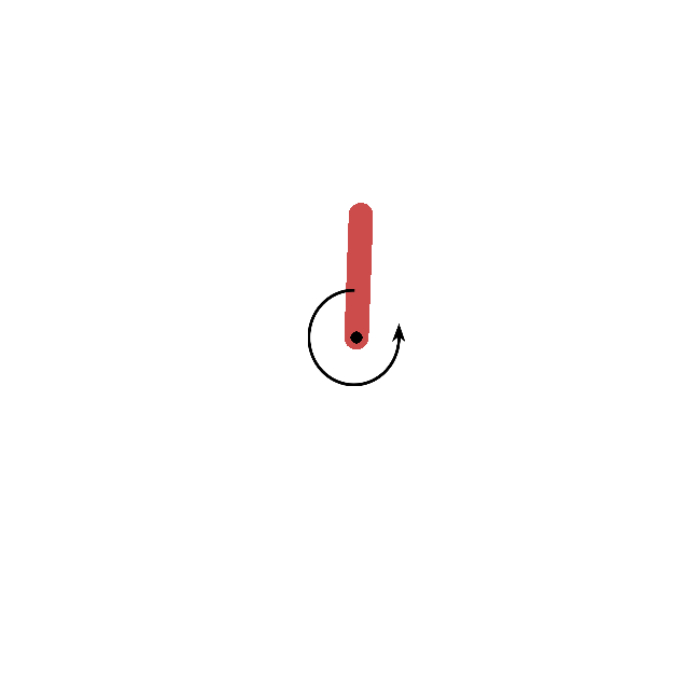
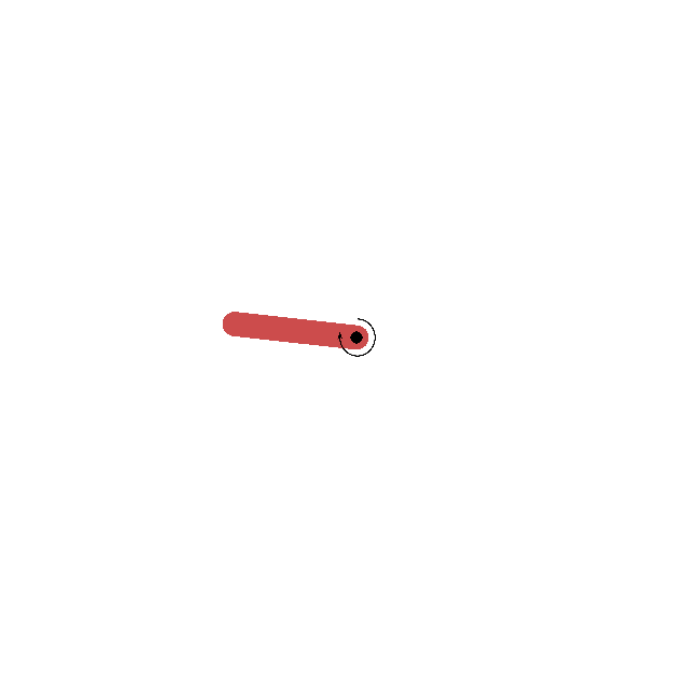
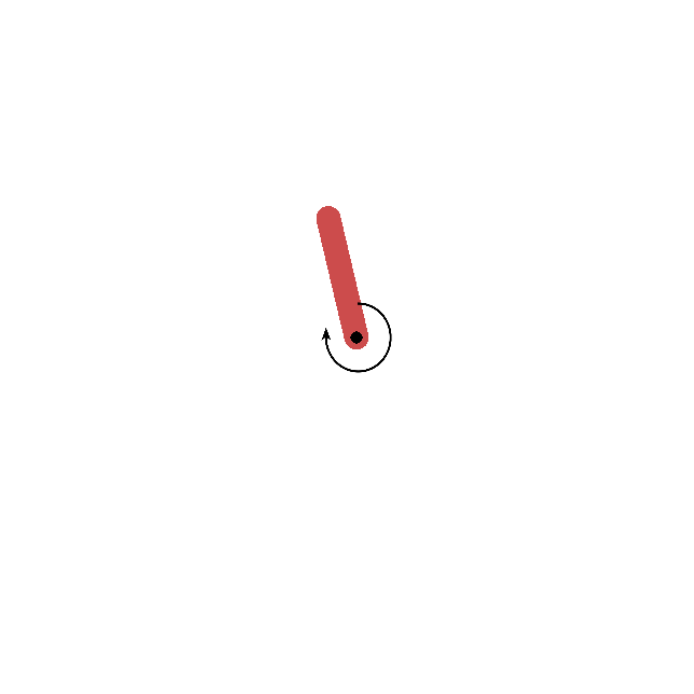
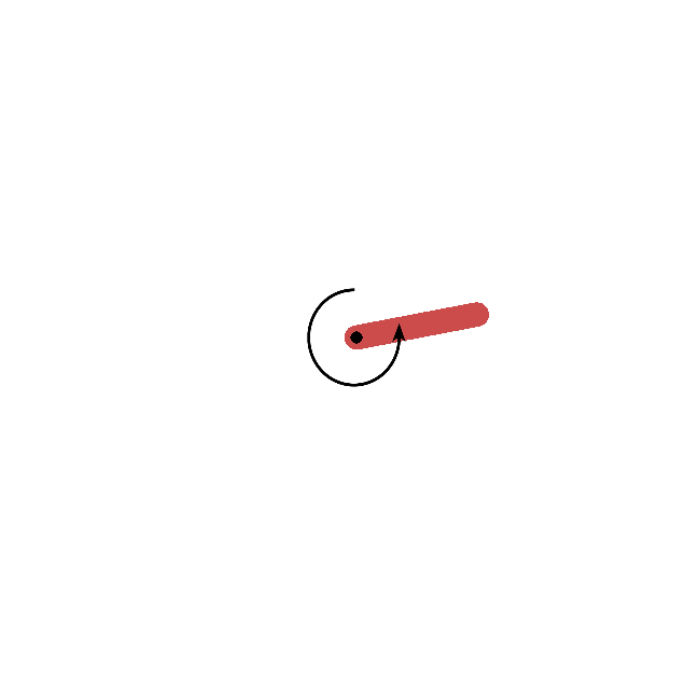
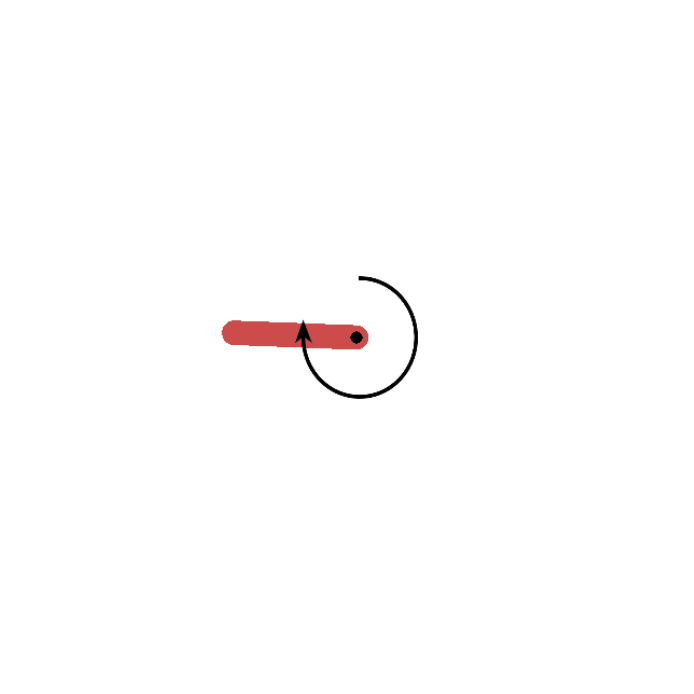
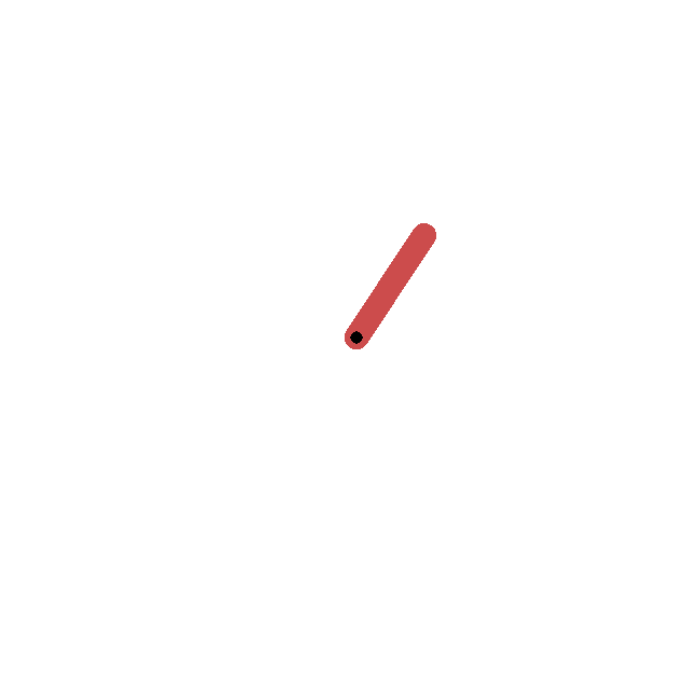
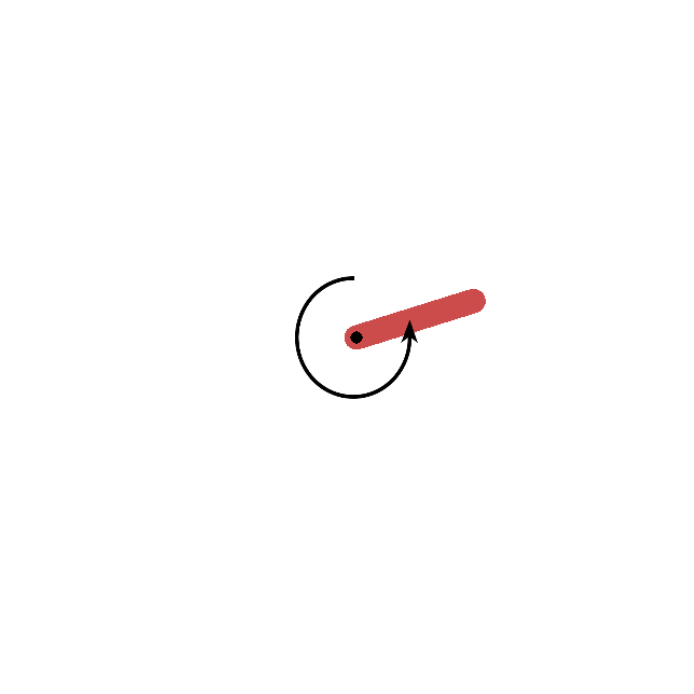
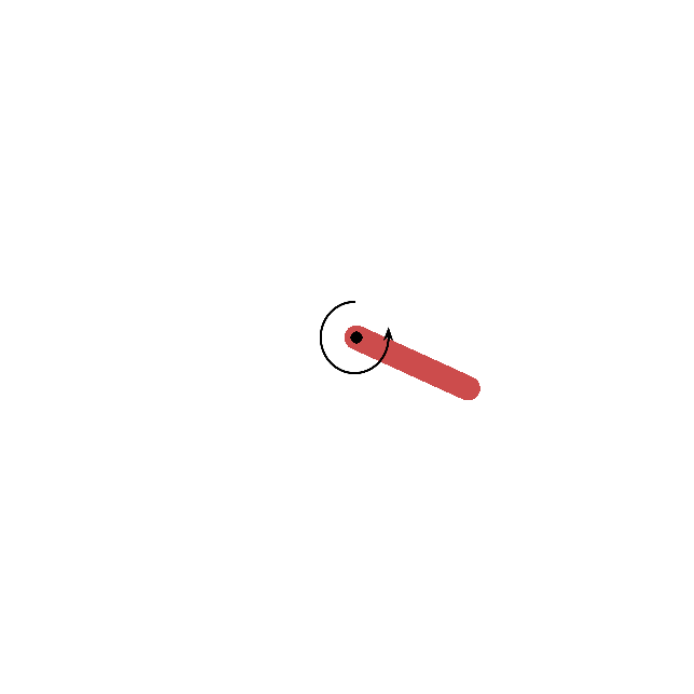
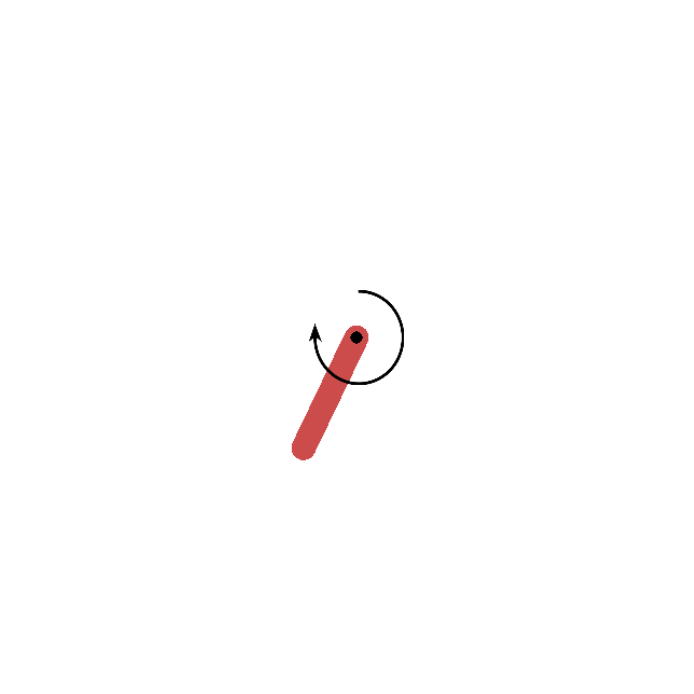
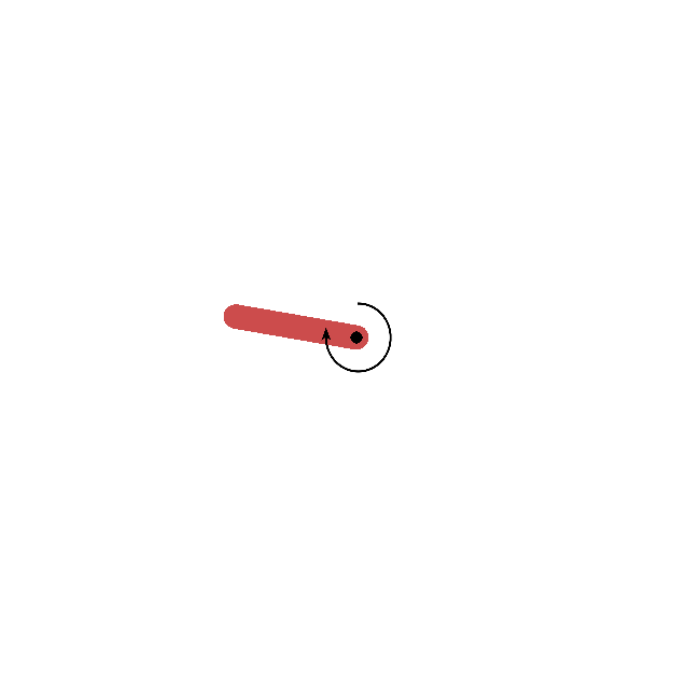
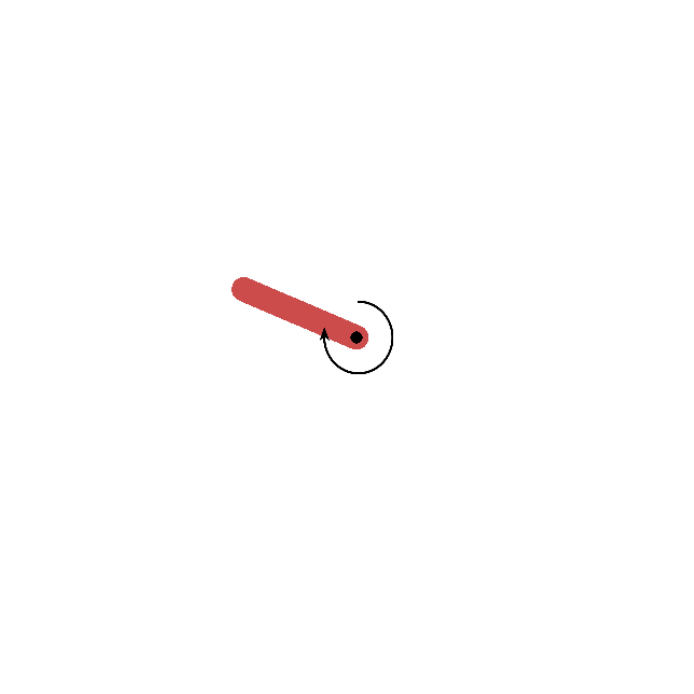
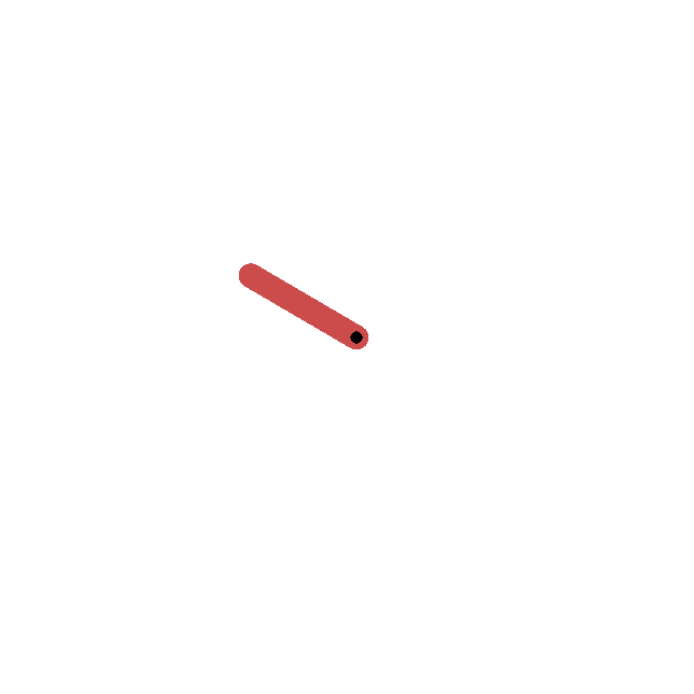
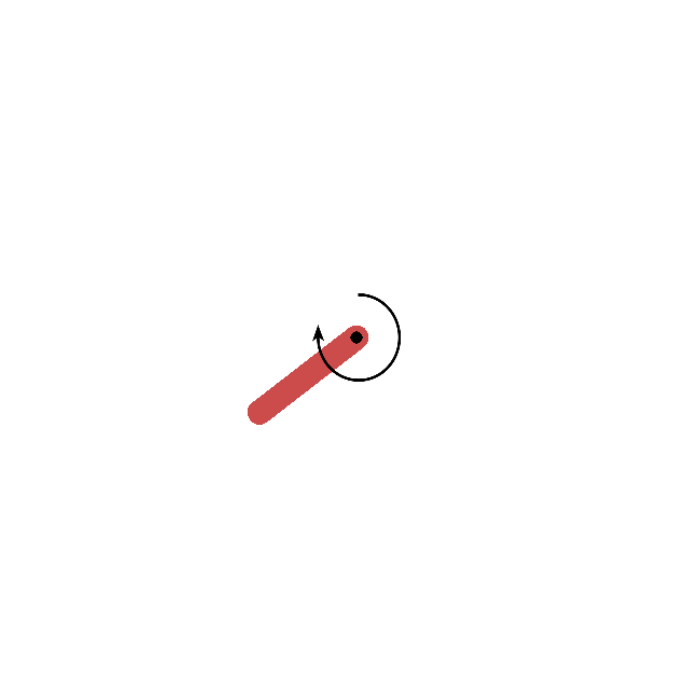
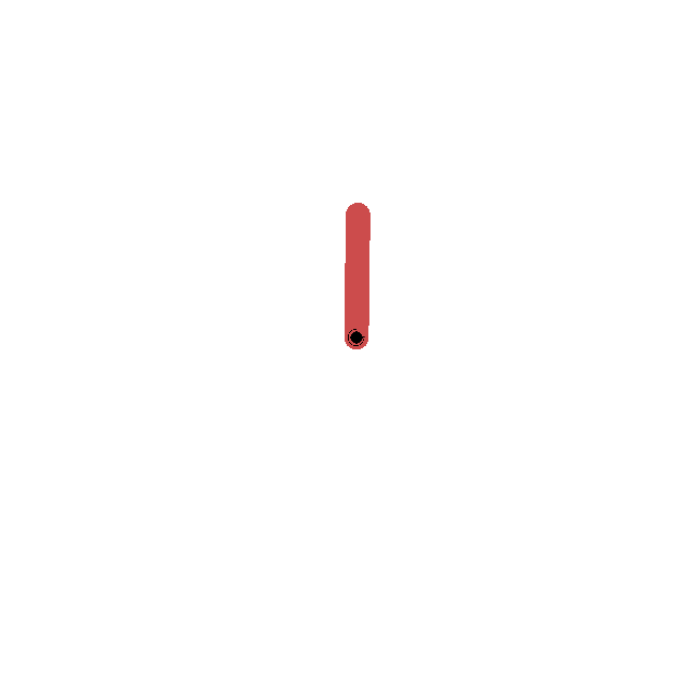
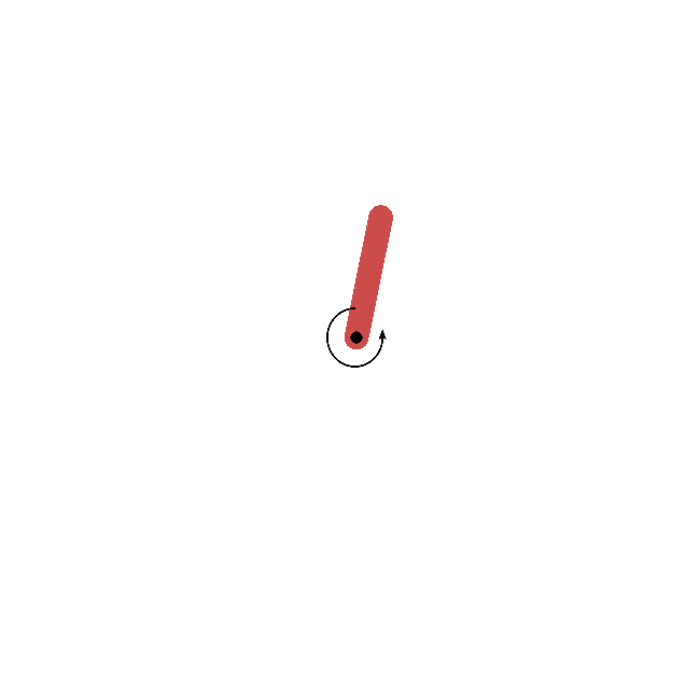
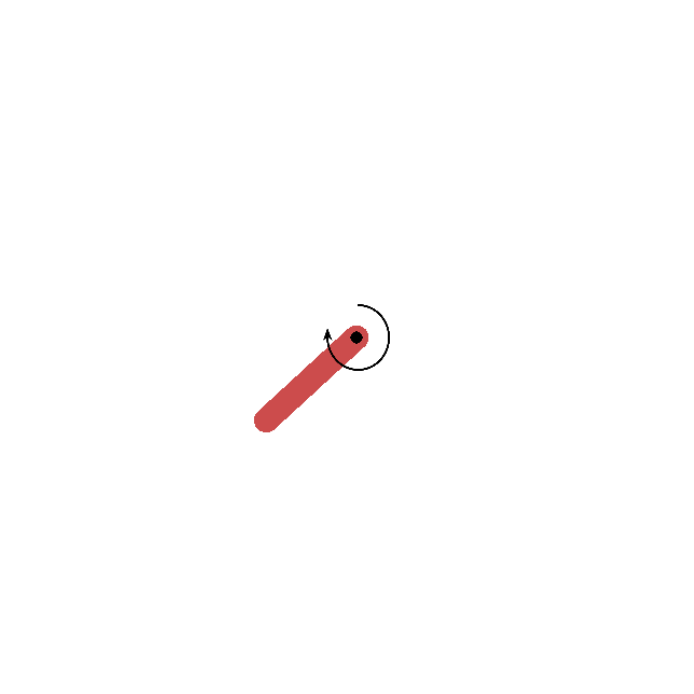
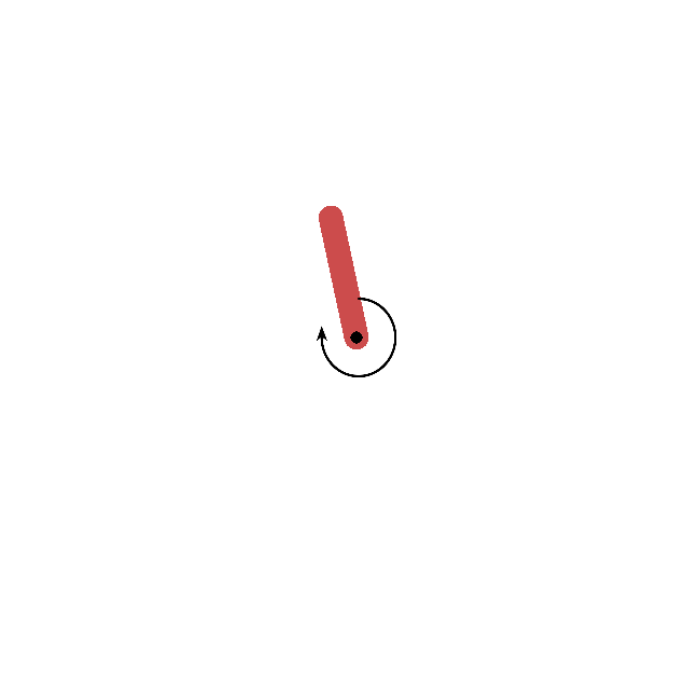
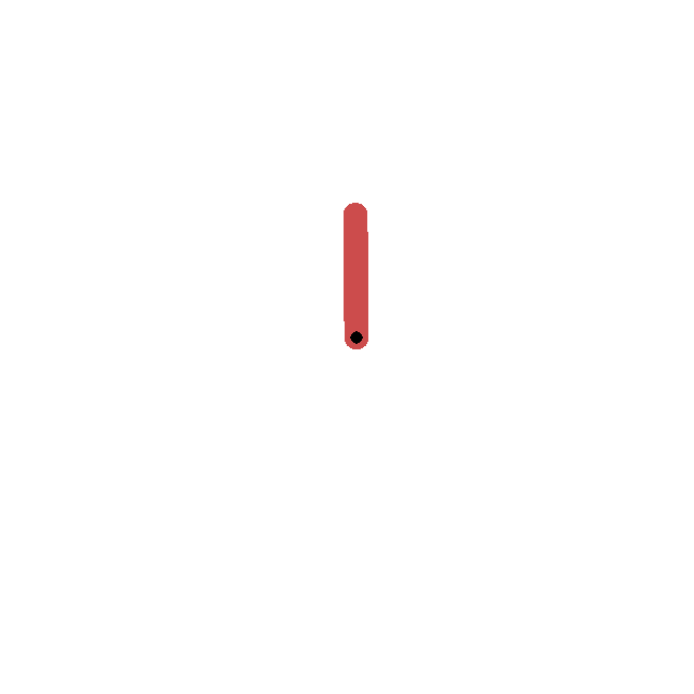
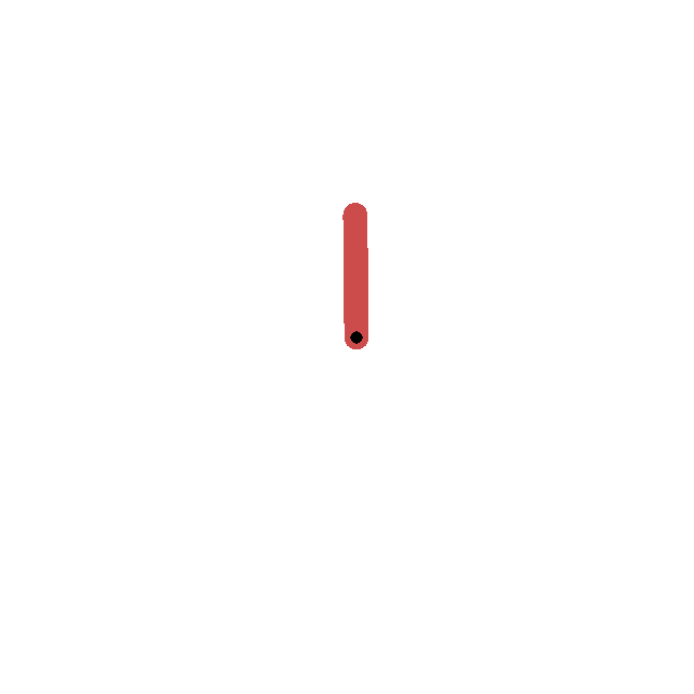
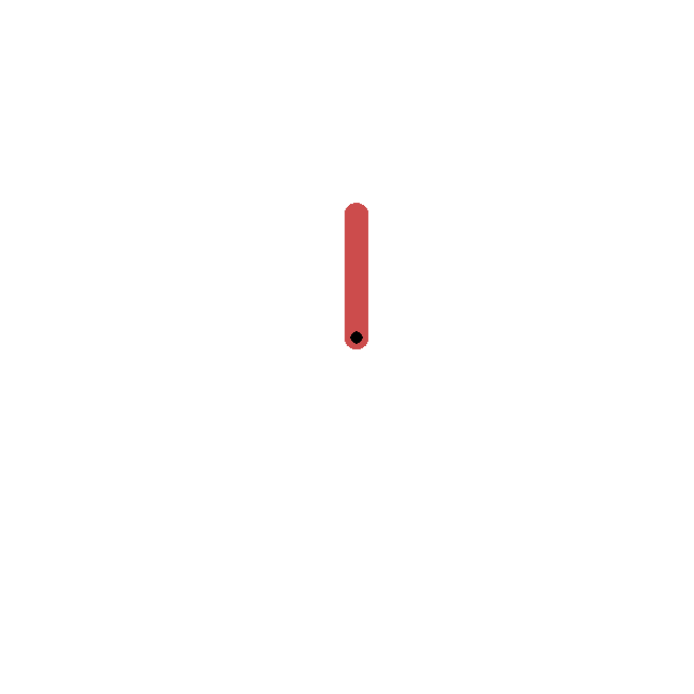
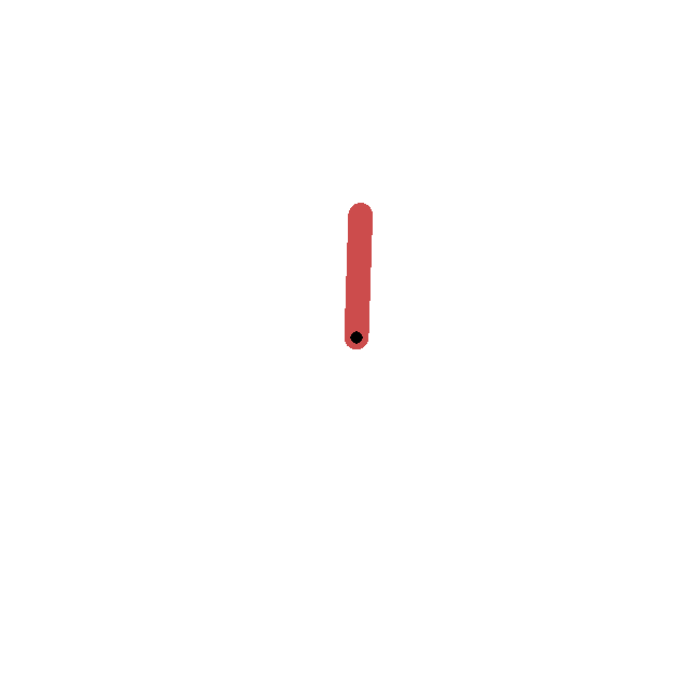
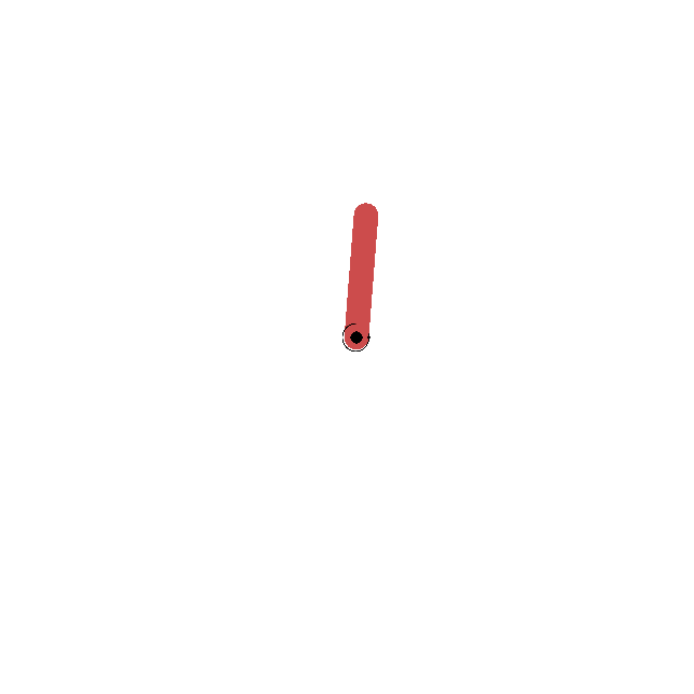
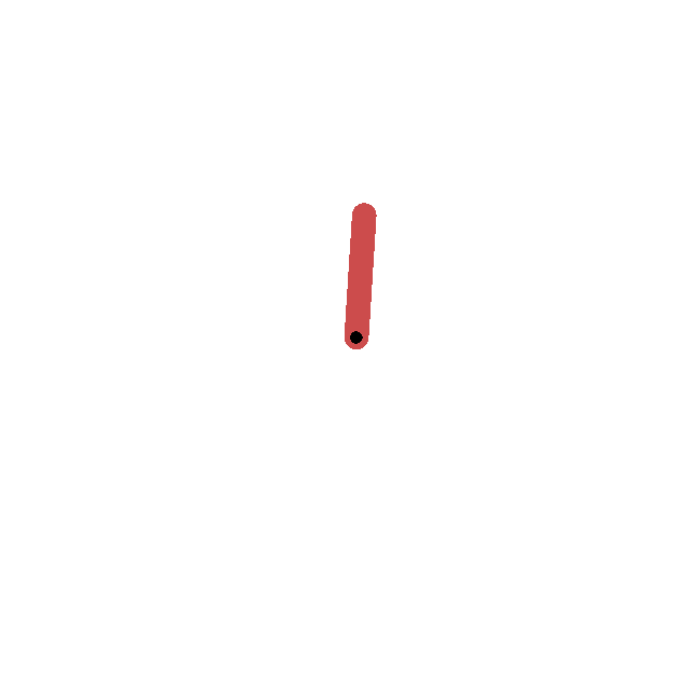
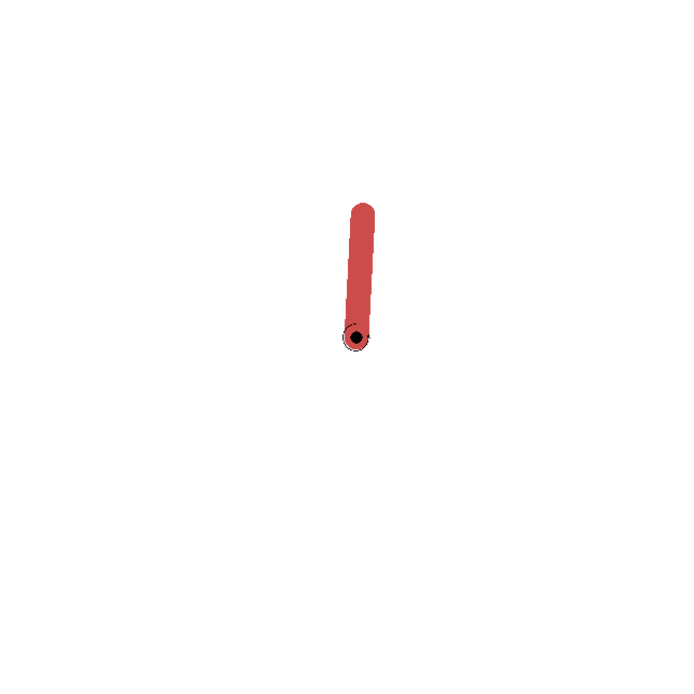
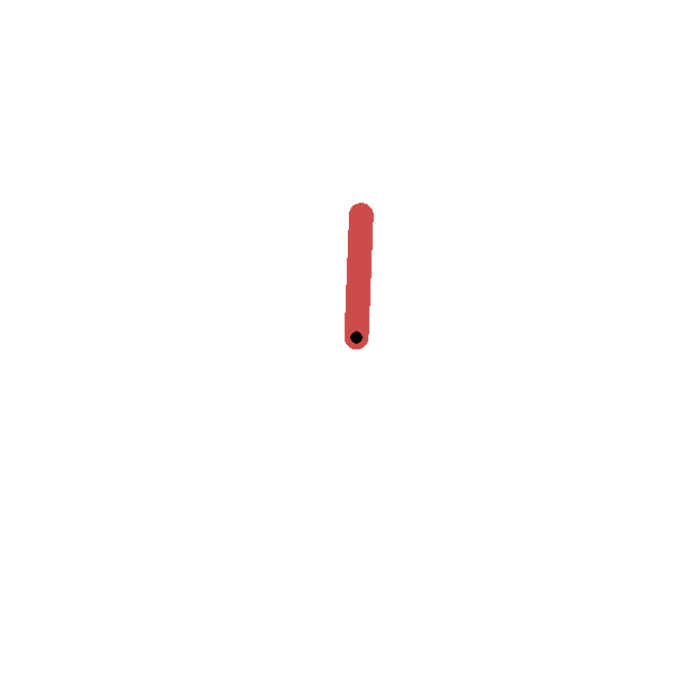
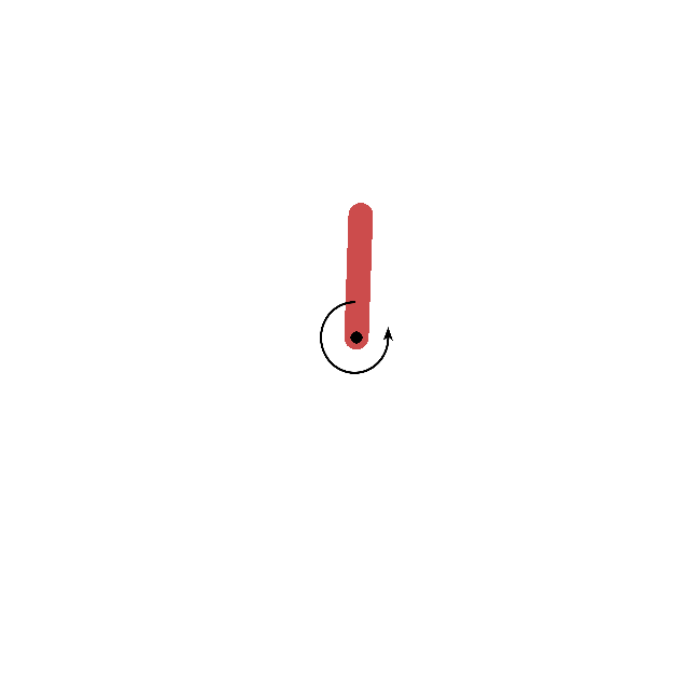
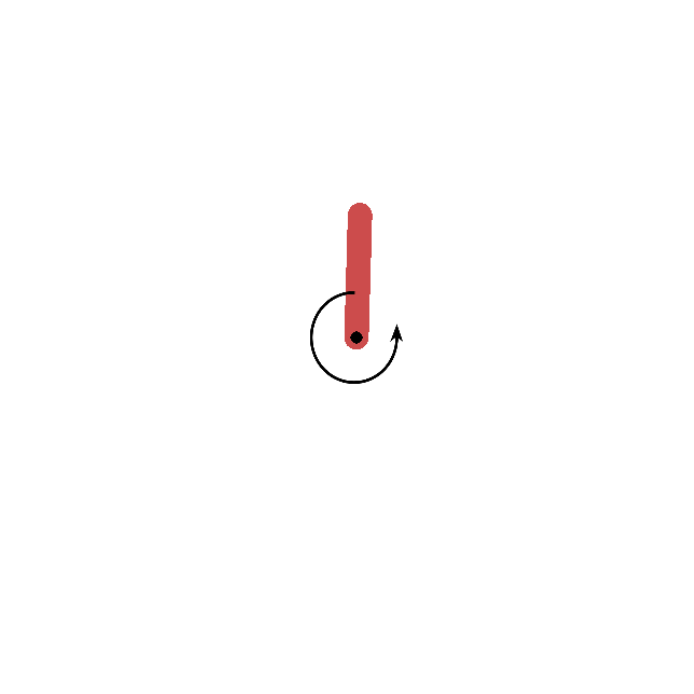
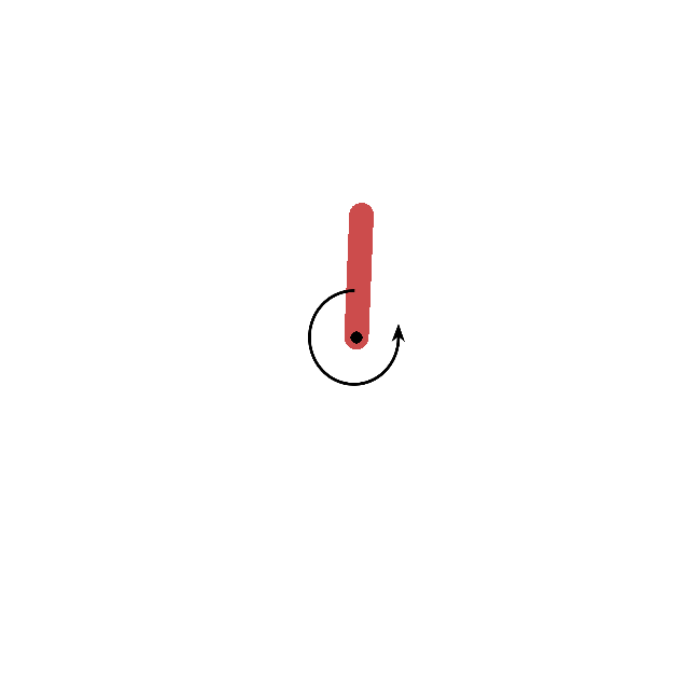

In [15]:
if settings["render_environment"]:
    exp.display_frames_as_gif()